<h2 align="center">Decatur, Illinois Data Prep</h2> 

In this notebook, we will investigate the seismicity induced by subsurface CO$_2$ injection in Decature, Illinois. Let's begin by studying the spatial distribution of induced seismic events. At the centroid of the induced seismicity, we will evaluate time series of pressure and pressurization rate.

In [1]:
# Load relevant packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from orion_light.pressure_table import PressureTableModel

### 1. Seismic Data 

In [2]:
# Read in seismic data.
seismic_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decaturSeismic.csv')

In [3]:
seismic_df.sample(10, random_state=440)

,b_value,b_value_epoch,depth,easting,epoch,event_id,latitude,longitude,magnitude,northing,source_radius,stress_drop
2543,1.324966,1.411376e+09,2035.763487,337694.879,1.376881e+09,3837.0,39.883824,-88.898150,-1.19,4416587.299,1.167327,0.1369
2937,1.112834,1.361686e+09,-1971.206949,338478.736,1.387301e+09,7081.0,39.884897,-88.889013,-1.69,4416689.748,0.749771,0.1080
1692,0.940971,1.388674e+09,2041.356294,338370.342,1.348342e+09,2570.0,39.884191,-88.890261,-0.07,4416613.653,1.481256,3.1462
2828,1.517922,1.451592e+09,1961.334959,338452.293,1.384465e+09,4217.0,39.884207,-88.889303,0.19,4416613.751,1.786041,5.3987
5236,0.933826,1.346742e+09,1917.976227,338656.029,1.489785e+09,6792.0,39.875504,-88.886682,-1.38,4415642.999,0.902164,0.1480
4920,0.926350,1.330554e+09,-2024.967998,338680.581,1.421883e+09,8061.0,39.873765,-88.886348,-1.67,4415449.375,1.481256,0.0210
1762,0.801082,1.410209e+09,2047.003962,337880.876,1.350179e+09,2673.0,39.879865,-88.895866,-0.18,4416143.639,1.990247,1.2694
4480,1.628604,1.358944e+09,-2110.268211,337743.185,1.410501e+09,7854.0,39.894523,-88.897880,-0.69,4417774.346,1.572691,0.2923
5252,1.186785,1.357402e+09,1911.664127,338565.077,1.496187e+09,6808.0,39.870801,-88.887617,-1.56,4415122.638,1.661079,0.0122
2987,1.196260,1.390092e+09,2056.278574,338489.131,1.388154e+09,4398.0,39.882460,-88.888825,-1.24,4416418.975,1.030174,0.1620


In [4]:
print('Do we have missing entries in our seismic data?') 
print(seismic_df.isnull().values.any())

Do we have missing entries in our seismic data?
False


In [5]:
# Reverse sign of depth if negative.
seismic_df.loc[seismic_df['depth']<0, 'depth'] *= -1
seismic_df.sample(10, random_state=440)

,b_value,b_value_epoch,depth,easting,epoch,event_id,latitude,longitude,magnitude,northing,source_radius,stress_drop
2543,1.324966,1.411376e+09,2035.763487,337694.879,1.376881e+09,3837.0,39.883824,-88.898150,-1.19,4416587.299,1.167327,0.1369
2937,1.112834,1.361686e+09,1971.206949,338478.736,1.387301e+09,7081.0,39.884897,-88.889013,-1.69,4416689.748,0.749771,0.1080
1692,0.940971,1.388674e+09,2041.356294,338370.342,1.348342e+09,2570.0,39.884191,-88.890261,-0.07,4416613.653,1.481256,3.1462
2828,1.517922,1.451592e+09,1961.334959,338452.293,1.384465e+09,4217.0,39.884207,-88.889303,0.19,4416613.751,1.786041,5.3987
5236,0.933826,1.346742e+09,1917.976227,338656.029,1.489785e+09,6792.0,39.875504,-88.886682,-1.38,4415642.999,0.902164,0.1480
4920,0.926350,1.330554e+09,2024.967998,338680.581,1.421883e+09,8061.0,39.873765,-88.886348,-1.67,4415449.375,1.481256,0.0210
1762,0.801082,1.410209e+09,2047.003962,337880.876,1.350179e+09,2673.0,39.879865,-88.895866,-0.18,4416143.639,1.990247,1.2694
4480,1.628604,1.358944e+09,2110.268211,337743.185,1.410501e+09,7854.0,39.894523,-88.897880,-0.69,4417774.346,1.572691,0.2923
5252,1.186785,1.357402e+09,1911.664127,338565.077,1.496187e+09,6808.0,39.870801,-88.887617,-1.56,4415122.638,1.661079,0.0122
2987,1.196260,1.390092e+09,2056.278574,338489.131,1.388154e+09,4398.0,39.882460,-88.888825,-1.24,4416418.975,1.030174,0.1620


We will now visualize the spatial distribution of the induced earthquakes with respect to its centroid.

In [6]:
# Compute centroid of induced seismicity as the arithmetic mean of coordinates of induced earthquakes. 
x_seismic_center = np.mean(seismic_df['easting'])
y_seismic_center = np.mean(seismic_df['northing'])
avg_depth = np.mean(seismic_df['depth'])

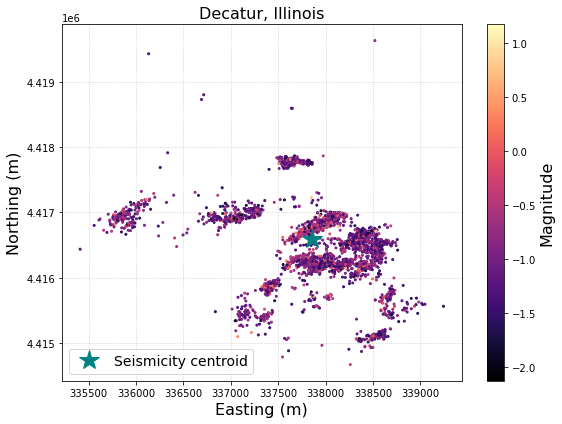

In [7]:
# Plot spatial distribution of induced earthquakes.
fig = plt.figure(figsize=(8,6))
plt.scatter(seismic_df['easting'], seismic_df['northing'], c=seismic_df['magnitude'], marker='o', s=4, cmap='magma')
plt.plot(x_seismic_center, y_seismic_center, linestyle='None', marker='*', ms=20, color='teal',
        label='Seismicity centroid')
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
h = plt.colorbar()
h.set_label('Magnitude', fontsize=16)
plt.legend(loc='best', prop={'size': 14})
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

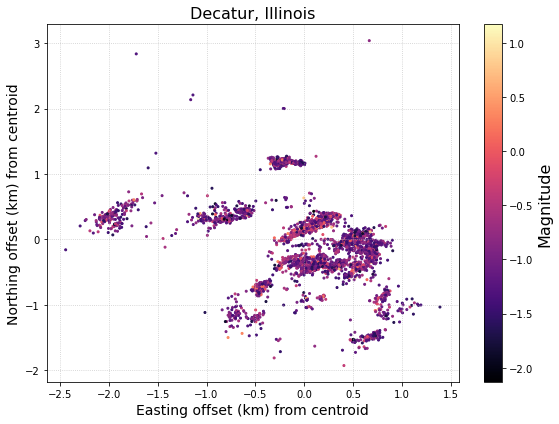

In [8]:
# Visualize above distribution relative to the coordinates of the computed centroid.
fig = plt.figure(figsize=(8,6))
plt.scatter((seismic_df['easting'] - x_seismic_center)*1e-3, 
            (seismic_df['northing'] - y_seismic_center)*1e-3, 
            c=seismic_df['magnitude'], marker='o', s=4, cmap='magma')
plt.xlabel('Easting offset (km) from centroid', fontsize=14)
plt.ylabel('Northing offset (km) from centroid', fontsize=14)
h = plt.colorbar()
h.set_label('Magnitude', fontsize=16)
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

Clearly, the seismic data are confined to a box of size 4 km $\times$ 5 km. Let's confirm by computing the exact spans of the inducced seismicity in easting, northing, and depth.

In [9]:
x_seismic_span = (seismic_df['easting'].max() - seismic_df['easting'].min())*1e-3
y_seismic_span = (seismic_df['northing'].max() - seismic_df['northing'].min())*1e-3
print('Easting range or x-span of induced seismicity = %.2f km'% (x_seismic_span))
print('Northing range or y-span of induced seismicity = %.2f km'% (y_seismic_span))

Easting range or x-span of induced seismicity = 3.83 km
Northing range or y-span of induced seismicity = 4.97 km


In [10]:
z_seismic_span = (seismic_df['depth'].max() - seismic_df['depth'].min())
print('Depth range or z-span of induced seismicity = %.2f m'% (z_seismic_span))
print('Minimum depth of seismic events = %.2f m'% (seismic_df['depth'].min()))
print('Maximum depth of seismic events = %.2f m'% (seismic_df['depth'].max()))

Depth range or z-span of induced seismicity = 1266.83 m
Minimum depth of seismic events = 1169.88 m
Maximum depth of seismic events = 2436.71 m


In [11]:
t_seismic_span = (seismic_df['epoch'].max() - seismic_df['epoch'].min())/(60*60*24*365.25) # s -> years
print('Time span of seismic data = %.2f years'% (t_seismic_span))

Time span of seismic data = 7.10 years


### 2. Pressure Data 

We have pressure data pre-computed over a grid of $(x,~y,~z,~t)$ values. The `PressureTableModel` class of `orion_light` numerically differentiates pressure to obtain `dp/dt`. We will then perform grid interpolation to compute values of pressure and `dp/dt` at the induced seismicity centroid.

**NOTE**: Our pressure data already incorporate in-situ spatial heterogeneity, and is therefore, superior to outputs from the radial flow model. Hence, for Decatur, we avoid computing pressures and `dp/dt` from injection flow rates using radial flow.

In [12]:
# Read in well location.
#loc_df = pd.read_csv('')

In [13]:
# Epochs
t_vals = np.squeeze(np.array(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/t.csv',
                   header=None)))
print('No. of epochs of pressure measurements = %d' % (len(t_vals)))

No. of epochs of pressure measurements = 228


In [14]:
# x-grid values
x_vals = np.squeeze(np.array(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/x.csv',
                   header=None)))
print('No. of x values = %d' % (len(x_vals)))

No. of x values = 64


In [15]:
# y-grid values
y_vals = np.squeeze(np.array(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/y.csv',
                   header=None)))
print('No. of y values = %d' % (len(y_vals)))

No. of y values = 56


In [16]:
# z-grid values
z_vals = np.squeeze(np.array(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/z.csv',
                   header=None)))
z_vals *= -1
z_vals = z_vals[::-1]
print('No. of z values = %d' % (len(z_vals)))

No. of z values = 17


In [17]:
# Pressure measurements
pressure = np.squeeze(np.array(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/pressure.csv',
                   header=None)))

In [18]:
pressure = pressure.reshape((len(x_vals), len(y_vals), len(z_vals), len(t_vals)), order='f')

pressure = np.flip(pressure, axis=2)
pressure_nd = pressure.copy()
pressure = pressure.flatten()
print('No. of pressure measurements = %d' % (len(pressure)))

No. of pressure measurements = 13891584


In [19]:
# Set up pressure table model.
flow_model = PressureTableModel()
data = {'t': t_vals,
        'x': x_vals,
        'y': y_vals,
        'z': z_vals,
        'pressure': pressure
       }

In [20]:
flow_model.load_array(**data)

In [21]:
np.where(pressure_nd==np.max(pressure_nd))

(array([51]), array([21]), array([0]), array([109]))

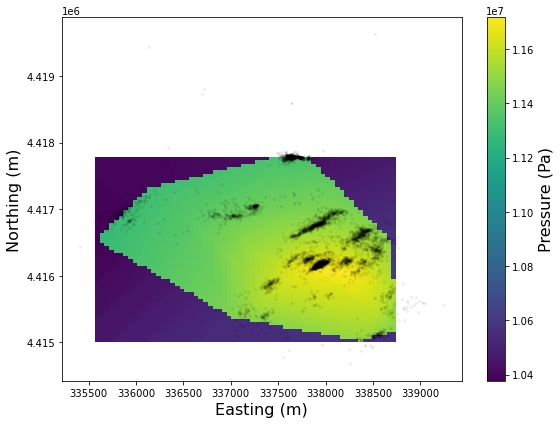

In [22]:
plot_p = pressure_nd[:,:,0, 109].T

fig = plt.figure(figsize=(8,6))
im = plt.imshow(plot_p, aspect='auto', interpolation='nearest', origin='lower',
                extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
# Overplot seismic events.
plt.scatter(seismic_df['easting'],seismic_df['northing'], c='k', marker='o', s=4, alpha=0.05)
h = plt.colorbar(im)
h.set_label('Pressure (Pa)', fontsize=16)
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
z_vals[0], t_vals[109]/(60*60*24*365.25)

(2149.0, 1.2739807031428245)

### 3. Grid setup

In [24]:
t_scale = 60*60*24*365.25 # s -> years

t_grid = np.linspace(0, t_seismic_span+0.2, 33)*t_scale

x_grid = np.linspace(np.min(x_vals), np.max(x_vals), 72)

y_grid = np.linspace(np.min(y_vals), np.max(y_vals), 60)

z_grid = np.array([seismic_df['depth'].min(), 2149.0, seismic_df['depth'].max()])

G = np.meshgrid(np.ascontiguousarray(x_grid), np.ascontiguousarray(y_grid), np.ascontiguousarray(z_grid), 
                np.ascontiguousarray(t_grid), indexing='ij')

In [25]:
len(x_grid), len(y_grid), len(z_grid), len(t_grid) 

(72, 60, 3, 33)

In [26]:
p = flow_model.p(*G)
p.shape

(72, 60, 3, 33)

In [27]:
np.where(p==np.nanmax(p))

(array([71]), array([16]), array([1]), array([7]))

In [28]:
z_grid[1], t_grid[6]/(60*60*24*365.25)

(2149.0, 1.369345452838619)

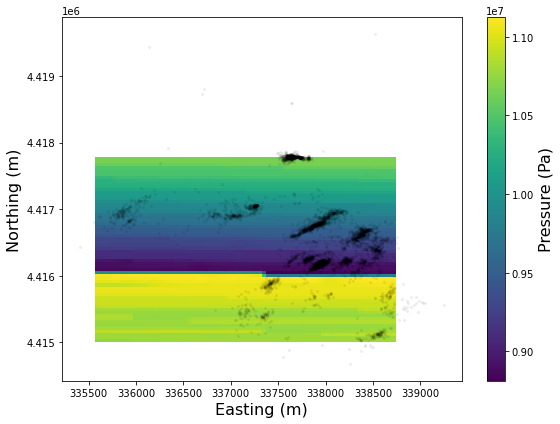

In [29]:
# Visualize pressure at central time and the lowest depth.
plot_p = p[:,:,1,6].T

fig = plt.figure(figsize=(8,6))
im = plt.imshow(plot_p, aspect='auto', interpolation='nearest', origin='lower',
                extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])
# Overplot seismic events.
plt.scatter(seismic_df['easting'],seismic_df['northing'], c='k', marker='o', s=4, alpha=0.05)
h = plt.colorbar(im)
h.set_label('Pressure (Pa)', fontsize=16)
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
plt.tight_layout()
plt.show()